In [29]:
# 1. Install Dependencies and Setup
%pip install tensorflow tensorflow-gpu opencv-python matplotlib
%pip list

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> [18 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "C:\Users\ADEBOSS\AppData\Local\Temp\pip-install-fw1x70vs\tensorflow-gpu_b8204932f6f34399aefa5afd52dabc4d\setup.py", line 37, in <module>
          raise Exception(TF_REMOVAL_WARNING)
      Exception:
      
      The "tensorflow-gpu" package has been removed!
      
      Please install "tensorflow" instead.
      
      Other than the name, the two packages have been identical
      since TensorFlow 2.1, or roughly since Sep 2019. For more
      information, see: pypi.org/project/tensorflow-gpu
      
      
      [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
ERROR: Could not bu

Package                      Version
---------------------------- -----------
absl-py                      1.4.0
asttokens                    2.2.1
astunparse                   1.6.3
autopep8                     2.0.0
backcall                     0.2.0
beautifulsoup4               4.11.1
blinker                      1.6.2
bs4                          0.0.1
cachetools                   5.3.0
certifi                      2022.12.7
cffi                         1.15.1
charset-normalizer           3.0.1
click                        8.1.3
colorama                     0.4.6
comm                         0.1.3
confusion-matrix             0.1
contourpy                    1.0.7
cycler                       0.11.0
dabl                         0.2.5
debugpy                      1.6.7
decorator                    5.1.1
dill                         0.3.6
dm-tree                      0.1.8
etils                        1.0.0
executing                    1.2.0
filelock                     3.12.0
Flask 

In [30]:
import tensorflow as tf
import os

In [31]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
tf.config.list_physical_devices('GPU')


[]

In [32]:
# 2. Remove dodgy images
import cv2
import imghdr

data_dir = 'ISIC/train'
image_exts = ['jpeg', 'jpg', 'bmp', 'png']
allowed_classes =['basal cell carcinoma', 'melanoma', 'squamous cell carcinoma']

for image_class in os.listdir(data_dir):
    if image_class not in allowed_classes:
        continue 
    
    for image in os.listdir(os.path.join(data_dir, image_class)):
        image_path = os.path.join(data_dir, image_class, image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with image {}'.format(image_path))
            os.remove(image_path)

Found 1043 files belonging to 3 classes.


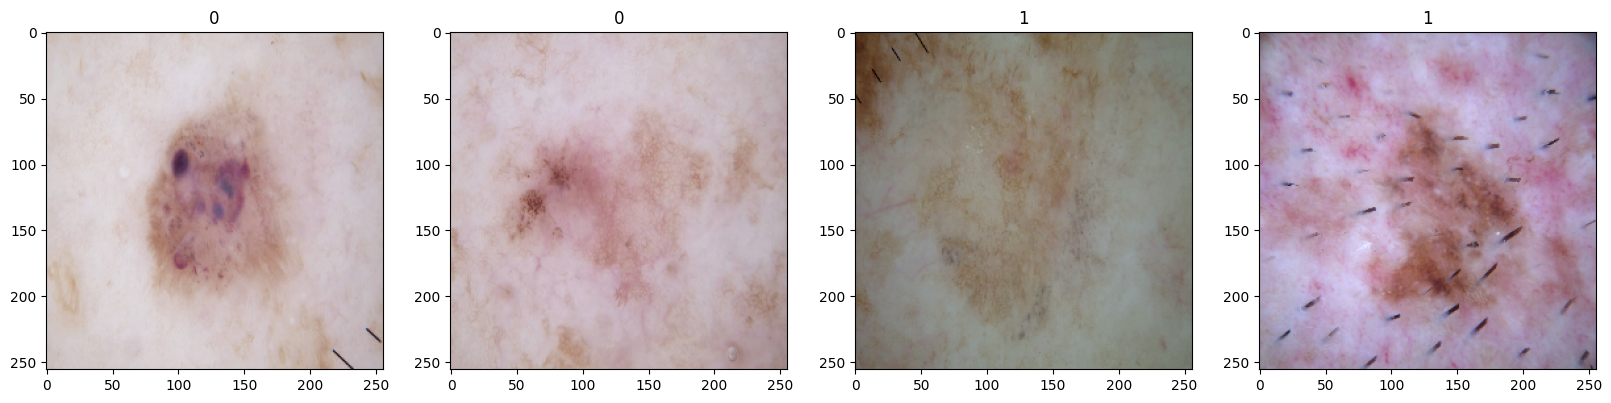

In [33]:
# 3. Load Data
import numpy as np
from matplotlib import pyplot as plt
data = tf.keras.utils.image_dataset_from_directory('ISIC/train', labels='inferred', label_mode='int',
                                                   class_names=allowed_classes)
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])
plt.show()

In [34]:
# 4. Scale Data
data = data.map(lambda x, y: (x / 255, y))
data.as_numpy_iterator().next()


(array([[[[0.3745098 , 0.2882353 , 0.16666667],
          [0.52156866, 0.42745098, 0.29411766],
          [0.5294118 , 0.43529412, 0.3019608 ],
          ...,
          [0.35686275, 0.2       , 0.09803922],
          [0.3509804 , 0.19411765, 0.09215686],
          [0.34313726, 0.19803922, 0.09215686]],
 
         [[0.36078432, 0.26078433, 0.13529412],
          [0.5254902 , 0.43137255, 0.29803923],
          [0.53137255, 0.4372549 , 0.30392158],
          ...,
          [0.34509805, 0.20392157, 0.10980392],
          [0.3392157 , 0.19803922, 0.10392157],
          [0.3254902 , 0.2       , 0.10196079]],
 
         [[0.37058824, 0.2529412 , 0.14705883],
          [0.47254902, 0.3745098 , 0.25686276],
          [0.5372549 , 0.44313726, 0.3019608 ],
          ...,
          [0.3764706 , 0.28627452, 0.16470589],
          [0.38627452, 0.26862746, 0.15882353],
          [0.38235295, 0.2764706 , 0.1627451 ]],
 
         ...,
 
         [[0.52156866, 0.4392157 , 0.32941177],
          [0.58823

In [35]:
# 5. Split Data
train_size = int(len(data) * 0.7)
val_size = int(len(data) * 0.2)
test_size = int(len(data) * 0.1)
train_size, val_size, test_size

train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)


In [36]:
# 6. Build Deep Learning Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout


In [37]:
model = Sequential()
model.add(Conv2D(16, (3, 3), 1, activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPooling2D())
model.add(Conv2D(32, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, (3, 3), 1, activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))  # 4 output classes
model.compile('adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

In [38]:
# 7. Train
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
hist = model.fit(train, epochs=30, validation_data=val, callbacks=[tensorboard_callback])


Epoch 1/30
23/23 [==============================] - 82s 3s/step - loss: 1.0023 - accuracy: 0.5584 - val_loss: 0.8613 - val_accuracy: 0.5833
Epoch 2/30
23/23 [==============================] - 65s 3s/step - loss: 0.8327 - accuracy: 0.6386 - val_loss: 1.0466 - val_accuracy: 0.4479
Epoch 3/30
23/23 [==============================] - 67s 3s/step - loss: 0.7117 - accuracy: 0.6984 - val_loss: 0.6254 - val_accuracy: 0.7396
Epoch 4/30
23/23 [==============================] - 69s 3s/step - loss: 0.6893 - accuracy: 0.7133 - val_loss: 0.6235 - val_accuracy: 0.7448
Epoch 5/30
23/23 [==============================] - 71s 3s/step - loss: 0.6373 - accuracy: 0.7283 - val_loss: 0.6017 - val_accuracy: 0.7396
Epoch 6/30
23/23 [==============================] - 71s 3s/step - loss: 0.5288 - accuracy: 0.7840 - val_loss: 0.5790 - val_accuracy: 0.6875
Epoch 7/30
23/23 [==============================] - 80s 3s/step - loss: 0.4966 - accuracy: 0.7867 - val_loss: 0.5382 - val_accuracy: 0.7917
Epoch 8/30
23/23 [==

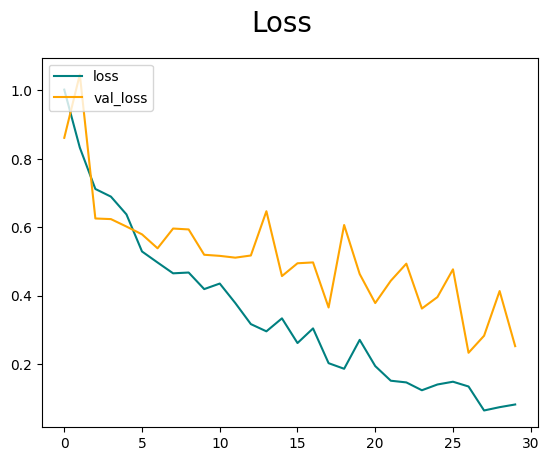

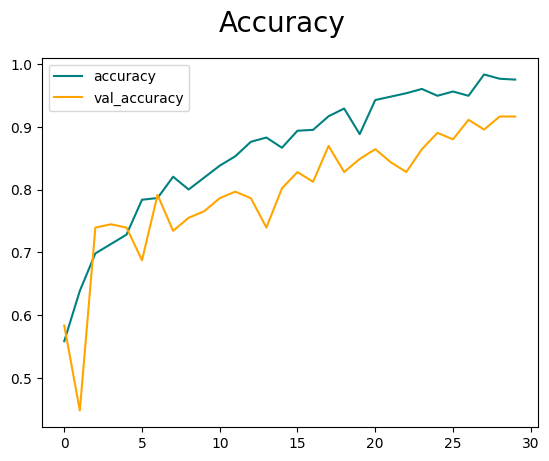

In [39]:
# 8. Plot Performance
fig = plt.figure()
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

fig = plt.figure()
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

In [40]:
# 9. Evaluate
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()
for batch in test.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    yhat_classes = np.argmax(yhat, axis=-1)  # Get the predicted class indices
    
    pre.update_state(y, yhat_classes)
    re.update_state(y, yhat_classes)
    acc.update_state(y, yhat_classes)
print(pre.result(), re.result(), acc.result())


1/1 [==============================] - 1s 686ms/step
tf.Tensor(0.9811321, shape=(), dtype=float32) tf.Tensor(0.88135594, shape=(), dtype=float32) tf.Tensor(0.7083333, shape=(), dtype=float32)


In [41]:
# 10. Test
import cv2

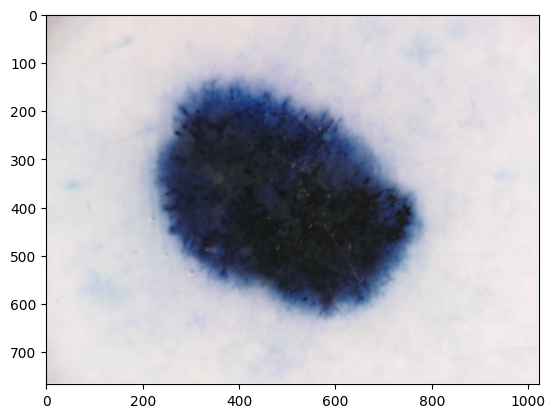

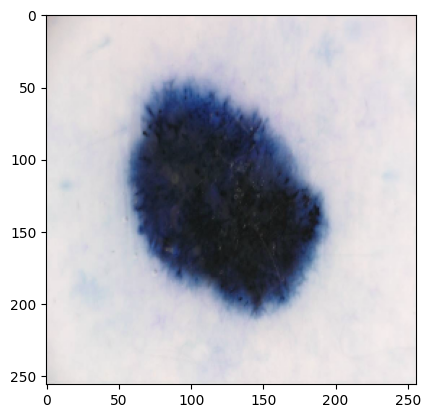

1/1 [==============================] - 0s 56ms/step
score : [array([[4.0501758e-02, 9.5890176e-01, 5.9647230e-04]], dtype=float32)]
Predicted class is a melanoma


In [44]:

img = cv2.imread('ISIC/Train/melanoma/ISIC_0000013.jpg')
plt.imshow(img)
plt.show()

resize = tf.image.resize(img, (256, 256))
plt.imshow(resize.numpy().astype(int))
plt.show()

yhat = model.predict(np.expand_dims(resize / 255, 0))
predicted_class = np.argmax(yhat)  # Get the index of the highest probability class

if classes[predicted_class] in allowed_classes:
    print(f'score : {[yhat]}')
    print(f'Predicted class is a {classes[predicted_class]}')
else:
    print('Error: Image does not belong to skin cancer class.')

In [43]:
# 11. Save the Model
from tensorflow.keras.models import load_model

model.save(os.path.join('models', 'imageclassifiers.h5'))
new_model = load_model('models/imageclassifiers.h5')
new_model.predict(np.expand_dims(resize / 255, 0))


1/1 [==============================] - 0s 158ms/step


array([[4.7458873e-36, 1.0000000e+00, 1.4154050e-23]], dtype=float32)